# Experimental Variogram Analysis

We require a covariance function or a variogram to perform interpolation with kriging methods that we discussed during the lecture. A valid question that came up several times during lecture  was just how do we determine this covariance (or the variogram) function? We will have a look at a method to perform this step in the following notebook.

Two weeks ago we detrended the DT (delta T) data of a well log. In this notebook we will now use this data again to determine an experimental variogram of the data set. For those of you who did not finisch that exercise, we also provided the detrended dataset (just depth and detrended DT) on Moodle.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Opening the detrended data set from data preparation exercise

The first step is, of course, to open the detrended data set so that we can use it here to determine the experimental variogram. This peice of code should work if you use the `data_detr.csv` provided on Moodle.

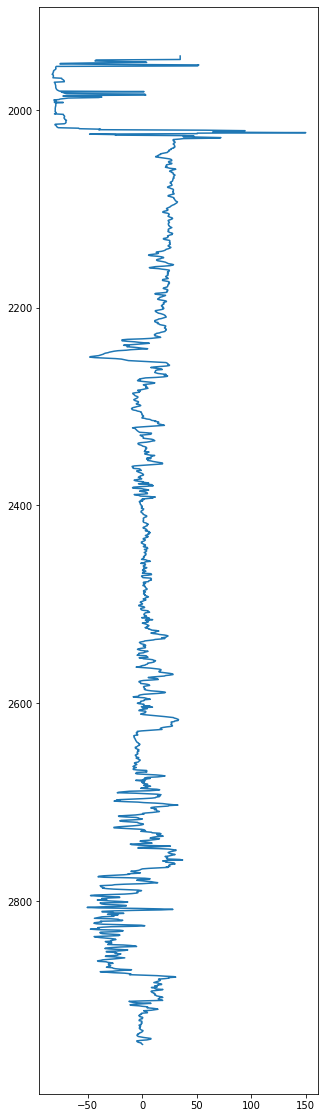

In [2]:
data = pd.read_csv('data_detr.csv')

# Plotting
plt.figure(figsize=(5,20))
plt.plot(data['DT'], data['DEPT'])
plt.gca().invert_yaxis()

In [3]:
data.head()

,DEPT,DT
0,1945.5,34.979732
1,1946.0,34.984350
2,1946.5,34.988967
3,1947.0,34.993585
4,1947.5,34.998202


## Creating an Experimental Variogram

Recall the calculation of the experimental variogram:

$$\hat{\gamma}(\vec{h}) = \frac{1}{2} \frac{1}{n} \sum_{\alpha=1}^n \left(z(\vec{x_\alpha}+\vec{h}) - z(\vec{x_\alpha})\right)^2 $$

Before we can calculate the experimental variogram values, we need to determine reasonable steps of $\vec{h}$ and tolerance values $\Delta \vec{h}$.

We will now use this data to create the experimental (semi-)variogram. In order to calculate a semivariance value for a specified distance $h$ and a tolerance level $tol$, we need to take the data points in the set, determine all values which are in a distance of $h +/- tol$, and add them to a list. We repeat this for all points in the data set, and finally calculate the (semi-)variance for the obtained list.

We will decompose this procedure into several steps.

### Step 1: 

We want to revisit how we can mask certain parts of a `numpy.array`. 

<div class='alert alert-info'>
    
**Your task**: Write a function to extract DT values (and corresponding distances h) from the data set which are at a distance $h = 10$ from the depth position $d = 2500$ with a tolerance of $tol = 5$. 

**Before you start coding**: Discuss with your group and draw a sketch: Which values  are you actually trying to extract - and what is described by the given parameters?

**Hint**: As stated before you will need masking operations. Take a look at `np.where`.

How can you check your result?
</div>

In [4]:
# input parameters
d = 2500 # depth position
lag = 10 # lag distance from depth position
tol = 5 # tolerance around lag distance

def single_data_extraction(data, depth, lag, tol):
    """Extract points within given lag and tolerance from defined depth.
    
    **Arguments**:
        - data = np.array : input array with depth and DT values
        - depth = int : z-positions from which to calcualte distances
        - lags = int : lag distance
        - tol = int : tolerance level
        
    **Returns**:
        - dt_vals = np.array : dt values within given lag and tolerance
        - h = np.array : corresponding alag distances
    """
    # Possible solution
    n = len(data[:,0]) # total number of data points
    z_pos = data[:,0] # all depth measurements
    vals = data[:,1] # all d_t measurements
    
    
    # calculate distance from each depth postiton to target position 
    h = np.abs(d-z_pos)
    # resulting array has same size as z_pos

    # creating a mask that is only true at positions with lag +- tol
    mask = np.where((h > (lag-tol)) & (h < (lag+tol)))
    # apply mask to distances 
    dist = h[mask]
    # apply same mask to vals
    dt_vals = vals[mask]
    
    return dt_vals, dist

# This calculates it here for the parameters defined above:
dt_vals, dist = single_data_extraction(data.values, d, lag, tol)


# Some things you could do to check results
print(np.max(dist))
print(np.min(dist))
print(dist)
#print(dist.shape)
#print(dt_vals.shape)

14.5
5.5
[14.5 14.  13.5 13.  12.5 12.  11.5 11.  10.5 10.   9.5  9.   8.5  8.
  7.5  7.   6.5  6.   5.5  5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5]


### Step 2: 

Now we want to create the full distance matrix (and corresponding matrix of semivariances). How big will this matrix be? Why? 

<div class='alert alert-info'>
    
**Your task**: Write a function that creates a distance matrix, meaning the matrix containing the distance from each point to each other and also calculate the respective semivariance (dissimilarity) in a separate matrix.

**Hint**: In this step you do not need the masking operations. If you do not know how to start exactly, draw a simple example with 5 points, discuss with your group and check the material on moodle.
</div>

In [15]:
def all_semivariances(data):
    """Calculate semivariance for single lag distance with defined tolerance.
    
    **Arguments**:
        - data = np.array : input array with depth and DT values.
        
    **Returns**:
        - gamma = np.array : semivariance for certain lag - the dissimilarity between two points at certain distance
        - h = np.array : corresponding lag distances
    """
    
    # Step 1: Create two empty matrices as containers of the correct size (n*n), one for all distances and one for 
    # the corresponding semivariances.
    n = len(data[:,0]) # total number of data points
    z_pos = data[:,0] # all depth measurements
    z_vals = data[:,1] # all d_t measurements
    h = np.abs(d-z_pos)
    dist_matrix = np.ones((n,n))
    semi_vmatrix = np.ones((n,n))
    
    
    # Step 2: Iterate through each location (depth position) and calculate the distance from this location 
    # to all other locations (see 1). Fill the rows and columns of your empty matrices accordingly. 
    # HINT: You can either create two nested for-loops or a single for-loop and a vectorized operation.
    
    for i in range(n):
        for j in range(n):
            dist_matrix[i,j] = np.abs(z_pos[i] - z_pos[j])
            semi_vmatrix[i,j] = (z_vals[i]-z_vals[j])**2/2
            
    # Step 3: Perform the same iteration calculating the semivariances based on the provided equation.
    
    return semi_vmatrix, dist_matrix


# The following code should work if you implemented the function correctly
# Calculate it for the complete dataset:
gamma, h = all_semivariances(data.values)

# This shows how many point pairs we have in total.
# Does it make sense? Why?
gamma.flatten().shape
print(len(h))


2000


We would like to plot the results, but actually this causes a little problem: The arrays for gamma and h each have nearly 4 million entries (and rememeber we already reduced the dataset), which is a little too much for `matplotlib` to handle sometimes. A workaround is to plot only a certain amount of entries. In order to not get a biased result due to the arrays being sorted, we can just plot every 10th entry. **Hint**: Look at the `numpy` slicing options again.

<div class='alert alert-info'>
    
**Your task**: Plot a reduced number (every 1000th) of the calculated semivariances against their respective lag distance h. What does the result look like? Did you expect that and what is the reason for this behavior?
</div>

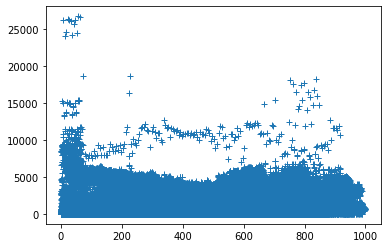

In [6]:
# YOUR CODE HERE
plt.plot(h.flatten()[0::10],gamma.flatten()[0::10], '+');

### Step 3: 

Finally we need to combine Step 1 and 2 to get a result that is easier to interpret. Start again by sketching out exactly what you want to do based on the plot above.

<div class='alert alert-info'>
    
**Your task**: Perform this analysis now for multiple ranges of lag values, taking the average value of semivariance for each bin (lag distance +/- tolerance), from $h = 0$ to $h = 500$ with a step size of $\Delta h = 10$ (twice the tolerance).

Discuss why 500 is a reasonable value for the maximumlag lag distance $h$.
</div>

In [7]:
start = 0
stop = 500
lag_step = 10 #basically twice the tolerance of 5

# Create one-d arrays if your previous results are in matrix form:
h = h.flatten()
gamma = gamma.flatten()

In [8]:
# Step 1: Calculate number of bins based on given parameters
n_bins = int((stop-start)/lag_step)


# Step 2: create empty container arrays of size equal to number of bins for the average 
# semivariance values and the central bin lag distance. Here just some good names:
ave_vals = np.ones(n_bins)
h_bins = np.ones(n_bins)
lower_boundary = 0
upper_boundary =10
# Step 3: Loop through range equal to number of bins

# 3.1 Create a mask (see 1) for distance step plus lag step (start with first bin)
mask = np.where((h>=lower_boundary)&(h<=upper_boundary))
        
# 3.2 apply mask to gamma and calculate and save average
ave_vals[0] = np.mean((gamma[mask]))
    
# 3.3 calculate value for the central lag distance for this bin and save
h_bins[0] = np.mean((upper_boundary,lower_boundary))
    
# 3.4 update distance step by lag step (going to next bin)
j = 1
while j > 0 and j < n_bins:
    lower_boundary += 10
    upper_boundary += 10
    mask = np.where((h>lower_boundary)&(h<=upper_boundary))
    ave_vals[j] = np.mean((gamma[mask]))
    h_bins[j] =np.mean((upper_boundary,lower_boundary))
    j += 1
        

In [9]:
# exp_variogram(gamma[mask])

Create a plot of the calculated variogram values:

Text(0, 0.5, 'Semi-variance')

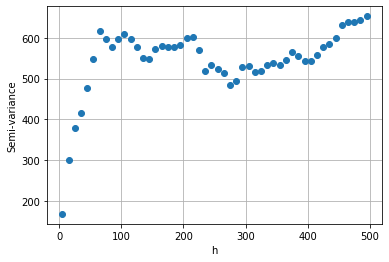

In [19]:
# Again this should work if everything is implemented properly
plt.plot(h_bins, ave_vals, 'o')
plt.grid()
plt.xlabel('h')
plt.ylabel('Semi-variance')

## Fit a (theoretical) variogram model

We can now use this experimental variogram to fit a variogram model. The most important decision at this step is now to determine the variogram model. Look at the shape above and decide on a reasonable model. We now need a way to fit the parameters of the variogram model to the data. There are several possibilities how to do this. One simple possibility is to use the function `scipy.optimize.curve_fit`.


In [11]:
import scipy.optimize
from scipy.optimize import curve_fit

In [12]:
# The exponential variogram function (just defined by this equation, recall lecture)
def exp_var(lag, r, c0):
    return c0 * (1 - np.exp((-3 * lag)/r))

First, we can simply try to fit a variogram by "eyeballing" the proper values of range and c0:

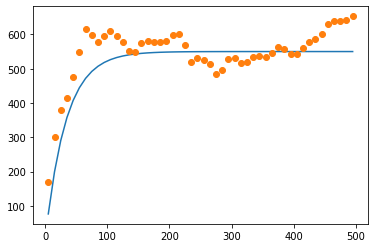

In [22]:
# Just from the plot, what do you think range and sill should be?
a = 100 #range
b = 550 #sill

# Plot the experimental variogram and the fit
plt.plot(h_bins, exp_var(h_bins, a, b))
plt.plot(h_bins, ave_vals, 'o')

Now the optimal fit:

[0.85399598 1.00000181]


C:\Users\adeko\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


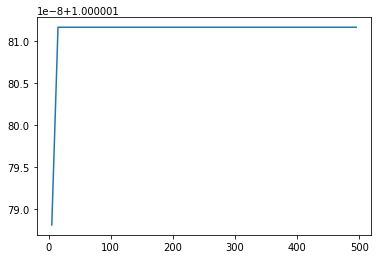

In [14]:
# Finding an optimal fit:
par_a, par_b = curve_fit(exp_var, h_bins, ave_vals)
print(par_a)

plt.plot(h_bins, exp_var(h_bins, par_a[0], par_a[1]))
